In [1]:
!pip install pydub

In [2]:
import ipywidgets as widgets
from IPython import display as disp
from IPython.display import display, Audio, clear_output
from google.colab import output
import base64
from pydub import AudioSegment
import io
import tempfile
import librosa

In [3]:
#
# original code: https://github.com/magenta/ddsp/blob/master/ddsp/colab/colab_utils.py
#


# Copyright 2020 The DDSP Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def record_audio(seconds=3,
                 sample_rate=44100,
                 normalize_db=0.1):
    """Record audio from the browser in colab using javascript.
    Based on: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
    Args:
      seconds: Number of seconds to record.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Use Javascript to record audio.
    record_js_code = """
      const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
      const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
      })
      var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
          blob = new Blob(chunks)
          text = await b2text(blob)
          resolve(text)
        }
        recorder.stop()
      })
      """
    print('Starting recording for {} seconds...'.format(seconds))
    display(disp.Javascript(record_js_code))
    audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
    print('Finished recording!')
    audio_bytes = base64.b64decode(audio_string.split(',')[1])
    return audio_bytes_to_np(audio_bytes,
                             sample_rate=sample_rate,
                             normalize_db=normalize_db)
    
def audio_bytes_to_np(wav_data,
                      sample_rate=44100,
                      normalize_db=0.1):
    """Convert audio file data (in bytes) into a numpy array.
    Saves to a tempfile and loads with librosa.
    Args:
      wav_data: A byte stream of audio data.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Parse and normalize the audio.
    audio = AudioSegment.from_file(io.BytesIO(wav_data))
    audio.remove_dc_offset()
    if normalize_db is not None:
        audio.normalize(headroom=normalize_db)
    # Save to tempfile and load with librosa.
    with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
        fname = temp_wav_file.name
        audio.export(fname, format='wav')
        audio_np, unused_sr = librosa.load(fname, sr=sample_rate)
    return audio_np

In [5]:
#@title Record
#@markdown * Set recording time:

SAMPLE_RATE = 44100
record_seconds =   10#@param {type:"number", min:1, max:10, step:1}

def _record_audio(b):
  global audio
  clear_output()
  audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
  display(Audio(audio, rate=SAMPLE_RATE))

button = widgets.Button(description="Start recording...")
button.on_click(_record_audio)
display(button)


Starting recording for 10 seconds...


<IPython.core.display.Javascript object>

Finished recording!


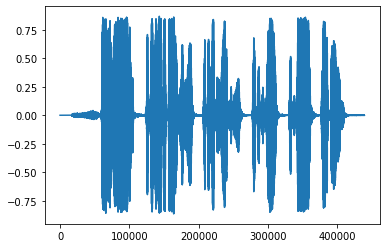

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(audio)